# Demo. Decoder Basics

In [1]:
import stim
import pymatching
import sys
sys.path.append("../QEC-Codes")  # Adjust the path to import local modules
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from numpy.typing import NDArray
import pandas as pd
import seaborn as sns
import time
from sklearn.metrics import r2_score

In [2]:
# QASM export setup (similar to surface_code_ler)
import os, sys, importlib
qasm_dir = "./bb_code72_qasm"
os.makedirs(qasm_dir, exist_ok=True)
# Make sure we can import the conversion utilities
sys.path.insert(0, os.path.abspath("../../../src"))
import noise_util as ns
importlib.reload(ns)

<module 'noise_util' from '/hpc/home/garn195/NWQ-Sim/stabilizer/src/noise_util.py'>

This demo introduces the basics of decoders, focusing on pymatching and BP+OSD.  

**What does decoder do?**  
The input is the error information/syndromes/detection events, along with the detector error model that assigns probability/weights to each error mechanism. For each sample, the decoder will return a vector that gives the predictions for the logical errors that have happened (for surface code it's just one value because there is only one logical operator, for general codes it should a vector).

### 1. Pymatching for repetition codes

### Overall Analysis  
**LER decreases with increasing code distance and decreasing physical error rate (PER).**  
This behavior is consistent with theoretical expectations: as the code distance increases, more physical errors are required to cause a logical error. Similarly, reducing the physical error rate naturally reduces the probability of uncorrectable faults.

<!-- (2) **The break-even PER appears to be ≈ 1, meaning the repetition code always outperforms a single bit.**  
At first glance, this seems to contradict the classical result that repetition codes only outperform a single bit when \( p < 0.5 \) — since majority vote fails above this threshold. However, the classical result is based on **majority vote decoding**, whereas our experiment uses a **matching decoder** (e.g., `pymatching`), which finds the most likely error consistent with the observed syndrome, and can operate effectively even at high error rates. As a result, it can outperform majority vote and maintain logical error suppression for a much wider range of \( p \), even approaching 1.

(3) **The error threshold appears to be >0.5, meaning that increasing the code distance can suppresses the LER even when the PER is large.**  
In standard fault-tolerance theory, a threshold exists below which increasing the code distance improves logical fidelity, and above which larger codes perform worse. Here, because we are using the powerful **matching decoder** on this simple repetition code, the threshold become very large (>0.5). -->

### Analysis of LER Scaling

In principle, a QEC code of distance $d$ can correct up to $t = \lfloor \frac{d-1}{2} \rfloor$ errors. In the **ideal** case where all these errors are corrected, the leading-order contribution to the LER should be $p^{t+1}$, where $t + 1 = \lceil \frac{d+1}{2} \rceil$ is the weight of uncorrectable errors. In this case, a log-log plot of LER vs $p$ should produce a straight line with slope $t + 1$.

In realistic scenarios, however, decoding is imperfect: some correctable errors of weight ≤ $t$ may still lead to logical failure due to decoder suboptimality. As a result, the effective scaling exponent becomes **less than** $t + 1$.

Therefore, by fitting the log-log curve $\log(\text{LER})$ vs $ \log(p) $, we can estimate the effective suppression exponent. The **closer the slope is to t+1**, the more effective the decoder is at approaching the ideal case. Conversely, the difference between the slope and the ideal case quantifies suboptimal correction performance under the given noise model and decoding strategy. We can see that when d increases, the leading degrees become closer to t than t+1 and haves the tendency to drop even below t, indicating the fact that it becomes more and more difficult to correct all the errors up to weight t.  

The equation $$slope = (d_{eff}+1)/2 $$can give a metric called the "effective distance $d_{eff}$", which should be strictly smaller than the true distance $d$.

Next, we verify the "exponential suppression" of LER in code distance.

In [3]:
import sinter
from typing import List

This time we try to add the 2Q gate error and measurement error as well.

(1) We kind of see a "threshold behavior": the LER only suppresses as distance increases when PER is below 10.8\%. See where the d = 7 and d = 9 line intersect.  
(2) We also see a "break even" behavior: the LER is belowe PER when p < 10\%, where encoding into repetition code improves the error resilience compared to a bare qubit.

### 2. Pymatching for Surface Codes  
We directly use Sinter to streamline the sampling. This time we include the BPOSD decoder as well.

In [4]:
from bposdd import BPOSD
import BBcode
# from stimbposdd import SinterDecoder_BPOSD, sinter_decoders

In [5]:
import subprocess
import time

# Compile the C++ code once before the loop
print("Compiling C++ simulator (MPI)...")
# Adjust the path to your C++ file as needed
cpp_file_path = './bb_code_sim.cpp'
executable_path = './bb_code_sim'

compile_command = [
    "mpicxx",  # Use MPI compiler wrapper
    "-std=c++17",
    "-O3",
    "-I../../../../../", # Include for NWQ-Sim headers
    "-DMPI_ENABLED",
    "-o",
    executable_path,
    cpp_file_path
]
try:
    subprocess.run(compile_command, check=True, capture_output=True, text=True)
    print("Compilation successful.")
except subprocess.CalledProcessError as e:
    print("Compilation failed.")
    print("--- stdout ---")
    print(e.stdout)
    print("--- stderr ---")
    print(e.stderr)

Compiling C++ simulator (MPI)...
Compilation successful.


In [6]:

# bb_circuit = "bicycle_bivariate_144_12_12_memory_Z"
distance = 6
rounds = 12
SHOTS = 5000000


In [7]:
#Parameters
tasks = []
T1 = 10 ** -4
T2 = 10 ** -4
tau = np.array([10**-7, 2*10**-7, 3*10**-7, 4*10**-7, 5*10**-7, 6*10**-7, 7*10**-7, 8*10**-7, 9*10**-7, 10**-6, 2*10**-6, 3*10**-6, 4*10**-6, 6*10**-6, 8*10**-6, 10**-5])
# tau = np.flip(np.array([3*10**-7, 7*10**-7]))

lam = 1/T2 - 1/(2*T1)
p_amp = 1 - np.exp(-tau/T1)
p_phase = 1 - np.exp(-lam*tau)
p_list = (p_amp, p_phase)
base_error = 10**-3

bb_code = BBcode.BBcode(
    n=72, k=12, d=6, m=6, l=6,
    A=[[3, 0], [0, 1], [0, 2]],
    B=[[0, 3], [1, 0], [2, 0]],
    shift=[0, 0],
    f=[[0, 0], [1, 0], [2, 0], [3, 0], [1, 3], [5, 3]],
    g=[[1, 0], [2, 1], [0, 2], [1, 2], [2, 3], [0, 4]],
    h=[[0, 0], [0, 1], [1, 1], [0, 2], [0, 3], [1, 3]],
    alpha=[[0, 0], [0, 1], [2, 1], [2, 5], [3, 2], [4, 0]],
    beta=[[0, 1], [0, 5], [1, 1], [0, 0], [4, 0], [5, 2]],
)

print(p_amp)
print(p_phase)
i=0
for p_amp, p_phase in zip(p_amp, p_phase):
    noise_profile = [0,0,0,0]
    bb_circuit = bb_code.build_full_BBcode_circuit(rounds=rounds, noise_profile=noise_profile, observable_type="Z", code_capacity=True)

    #Generate stim circuit
    model = ns.ErrorModel(bb_circuit)
    model.setting_error('Identity', False, f'DEPOLARIZE1({base_error})')
    model.setting_error('Single_qubit', False, f'DEPOLARIZE1({base_error})')
    model.setting_error('Two_qubit', False, f'DEPOLARIZE2({base_error})')
    model.setting_error('Measurement', True, f'DEPOLARIZE1({p_amp/4})') #f'PAULI_CHANNEL_1({p_amp/4}, {p_amp/4}, {((1-np.sqrt((1-p_amp)*(1-p_phase)))/2)-p_amp/4})')
    model.setting_error('Reset', True, f'DEPOLARIZE1({p_amp/4})') #'PAULI_CHANNEL_1({p_amp/4}, {p_amp/4}, {((1-np.sqrt((1-p_amp)*(1-p_phase)))/2)-p_amp/4})')
    stim_circuit = model.generate_noisy_circuit()
    tasks.append(sinter.Task(circuit=stim_circuit, json_metadata={'d': distance, "trial":i}))

    #Generate stabsim circuit   
    model.setting_error('Measurement', True, f'AMPLITUDE_DAMP({p_phase}, {p_amp})')
    model.setting_error('Reset', True, f'AMPLITUDE_DAMP({p_phase}, {p_amp})')
    stab_circuit = model.generate_noisy_circuit()
    qasm_output = ns.stim_to_qasm_with_depolarize_noise(stab_circuit)
    # Inject AMPLITUDE_DAMP around M/RESET in QASM using the model settings
    qasm_output = ns.inject_amplitude_damp(qasm_output, model)
    
    try:
        qasm_path = os.path.join(qasm_dir, f"bb_code_d{distance}_p{i}.qasm")
        with open(qasm_path, "w") as f:
            f.write(qasm_output)
    except Exception as e:
        print(f"Failed to export QASM for p={p_amp}: {e}")
    i+=1

print(tau)

[0.0009995  0.001998   0.0029955  0.00399201 0.00498752 0.00598204
 0.00697556 0.00796809 0.00895962 0.00995017 0.01980133 0.02955447
 0.03921056 0.05823547 0.07688365 0.09516258]
[0.00049988 0.0009995  0.00149888 0.001998   0.00249688 0.0029955
 0.00349388 0.00399201 0.00448989 0.00498752 0.00995017 0.01488806
 0.01980133 0.02955447 0.03921056 0.04877058]
[1.e-07 2.e-07 3.e-07 4.e-07 5.e-07 6.e-07 7.e-07 8.e-07 9.e-07 1.e-06
 2.e-06 3.e-06 4.e-06 6.e-06 8.e-06 1.e-05]


In [8]:
stim_circuit.diagram('timeline-svg')

In [9]:
print(len(bb_code.data_coords))

print(bb_code.get_info()['logical_X'])

72
[[(0, 1), (2, 1), (4, 1), (6, 1), (2, 7), (10, 7)], [(2, 1), (4, 3), (0, 5), (2, 5), (4, 7), (0, 9), (1, 0), (1, 2), (3, 2), (1, 4), (1, 6), (3, 6)], [(0, 3), (2, 3), (4, 3), (6, 3), (2, 9), (10, 9)], [(2, 3), (4, 5), (0, 7), (2, 7), (4, 9), (0, 11), (1, 2), (1, 4), (3, 4), (1, 6), (1, 8), (3, 8)], [(4, 3), (6, 3), (8, 3), (10, 3), (6, 9), (2, 9)], [(6, 3), (8, 5), (4, 7), (6, 7), (8, 9), (4, 11), (5, 2), (5, 4), (7, 4), (5, 6), (5, 8), (7, 8)], [(4, 11), (6, 11), (8, 11), (10, 11), (6, 5), (2, 5)], [(6, 11), (8, 1), (4, 3), (6, 3), (8, 5), (4, 7), (5, 10), (5, 0), (7, 0), (5, 2), (5, 4), (7, 4)], [(6, 5), (8, 5), (10, 5), (0, 5), (8, 11), (4, 11)], [(8, 5), (10, 7), (6, 9), (8, 9), (10, 11), (6, 1), (7, 4), (7, 6), (9, 6), (7, 8), (7, 10), (9, 10)], [(8, 1), (10, 1), (0, 1), (2, 1), (10, 7), (6, 7)], [(10, 1), (0, 3), (8, 5), (10, 5), (0, 7), (8, 9), (9, 0), (9, 2), (11, 2), (9, 4), (9, 6), (11, 6)]]


In [10]:
def run_stim_experiment(tasks, shots):
    stim_lers = []
    for i,task in enumerate(tasks):
        print(f"trial={task.json_metadata.get('trial')}")
        print(f"--- Running Stim for task = {i} ---")
        start_time = time.perf_counter()
        collected_stats = sinter.collect(
            num_workers=os.cpu_count()//2,
            tasks=[task],
            decoders=['bposd'],
            max_shots=shots,
            custom_decoders={
                'bposd': BPOSD(
                    max_iter=1000,
                    bp_method="ms",
                    osd_order=10,
                    osd_method="osd_e"
                )
            },
            print_progress=True,
        )
        stim_time = time.perf_counter() - start_time
        stat = collected_stats[0]
        stim_ler = stat.errors / stat.shots
        if stat.errors == 0: stim_ler = 0
        stim_lers.append(stim_ler)
        print(f"Stim LER: {stim_ler}, Sim+Decoding Time: {stim_time:}s\n")
    return stim_lers

# --- Run Stim-only experiment ---
stim_logical_error_rates = run_stim_experiment(tasks, SHOTS)
print("\nStim complete.")
print("Stim LERs:", stim_logical_error_rates)

try:
    results_dir = "./bposd_72_results"
    os.makedirs(results_dir, exist_ok=True)
    p_amp_arr = 1 - np.exp(-tau / T1)
    lam = 1 / T2 - 1 / (2 * T1)
    p_phase_arr = 1 - np.exp(-lam * tau)
    stim_results_path = os.path.join(results_dir, f"stim_bposd_results_d{distance}_shots{SHOTS}.txt")
    with open(stim_results_path, "w") as f:
        f.write("# tau\tp_amp\tp_phase\tstim_ler\n")
        for ta, pa, pp, ler in zip(tau, p_amp_arr, p_phase_arr, stim_logical_error_rates):
            f.write(f"{ta}\t{pa}\t{pp}\t{ler}\n")
    print(f"Saved Stim (BP+OSD) results to {stim_results_path}")
except Exception as e:
    print("Failed to save Stim results:", e)


Starting 224 workers...


trial=0
--- Running Stim for task = 0 ---


1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4999999           0 d=6,trial=0  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4987331           0 d=6,trial=0  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4939360           0 d=6,trial=0  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4938848           0 d=6,trial=0  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4938336           0 d=6,trial=0  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4913248           0 d=6,trial=0  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4740192           0 d=6,trial=0  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
   

Stim LER: 0, Sim+Decoding Time: 14.508269636004115s

trial=1
--- Running Stim for task = 1 ---


1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4999999           0 d=6,trial=1  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4997909           0 d=6,trial=1  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4947585           0 d=6,trial=1  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4938848           0 d=6,trial=1  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4937824           0 d=6,trial=1  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4905056           0 d=6,trial=1  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4871264           0 d=6,trial=1  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
   

Stim LER: 0, Sim+Decoding Time: 16.52445908098889s

trial=2
--- Running Stim for task = 2 ---


1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4999999           0 d=6,trial=2  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4997441           0 d=6,trial=2  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4973552           0 d=6,trial=2  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4939104           0 d=6,trial=2  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4938336           0 d=6,trial=2  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4908128           0 d=6,trial=2  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4853344           0 d=6,trial=2  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
   

Stim LER: 6e-07, Sim+Decoding Time: 17.698954740000772s

trial=3
--- Running Stim for task = 3 ---


1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4999999           0 d=6,trial=3  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4999769           0 d=6,trial=3  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4998818           0 d=6,trial=3  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4978403           0 d=6,trial=3  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4938848           0 d=6,trial=3  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4877920           0 d=6,trial=3  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4861536           0 d=6,trial=3  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
   

Stim LER: 8e-07, Sim+Decoding Time: 18.50069300099858s

trial=4
--- Running Stim for task = 4 ---


1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4999999           0 d=6,trial=4  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4997937           0 d=6,trial=4  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4975680           0 d=6,trial=4  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4939616           0 d=6,trial=4  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4938848           0 d=6,trial=4  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4930656           0 d=6,trial=4  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4852832           0 d=6,trial=4  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
   

Stim LER: 1.8e-06, Sim+Decoding Time: 19.462890511989826s

trial=5
--- Running Stim for task = 5 ---


1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd  1m    4999999           0 d=6,trial=5  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4997285           0 d=6,trial=5  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4979216           0 d=6,trial=5  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4941152           0 d=6,trial=5  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4938848           0 d=6,trial=5  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4925024           0 d=6,trial=5  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4876384           0 d=6,trial=5  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
   

Stim LER: 3.8e-06, Sim+Decoding Time: 19.816395381989423s

trial=6
--- Running Stim for task = 6 ---


1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4999999           0 d=6,trial=6  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4997418           0 d=6,trial=6  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4972160           0 d=6,trial=6  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4941664           0 d=6,trial=6  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4938848           0 d=6,trial=6  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4935776           0 d=6,trial=6  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4880992           0 d=6,trial=6  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
   

Stim LER: 4e-06, Sim+Decoding Time: 20.271441154996864s

trial=7
--- Running Stim for task = 7 ---


1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4999999           0 d=6,trial=7  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4997574           0 d=6,trial=7  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4979681           0 d=6,trial=7  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4943456           1 d=6,trial=7  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4938848           1 d=6,trial=7  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4934752           1 d=6,trial=7  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4891232           2 d=6,trial=7  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
   

Stim LER: 5.8e-06, Sim+Decoding Time: 20.45778186401003s

trial=8
--- Running Stim for task = 8 ---


1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd  1m    4999999           0 d=6,trial=8  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4997283           0 d=6,trial=8  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4967520           0 d=6,trial=8  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4940640           0 d=6,trial=8  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4938848           0 d=6,trial=8  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4919392           0 d=6,trial=8  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4865632           0 d=6,trial=8  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
   

Stim LER: 9.6e-06, Sim+Decoding Time: 20.31757249799557s

trial=9
--- Running Stim for task = 9 ---


1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4999999           0 d=6,trial=9  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4997076           0 d=6,trial=9  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4983792           0 d=6,trial=9  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4943968           0 d=6,trial=9  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4938848           0 d=6,trial=9  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4932704           0 d=6,trial=9  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4895328           0 d=6,trial=9  
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
   

Stim LER: 1.3e-05, Sim+Decoding Time: 20.863916057991446s

trial=10
--- Running Stim for task = 10 ---


1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd  1m    4999999           0 d=6,trial=10 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4997205           0 d=6,trial=10 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4985058           0 d=6,trial=10 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4944992           4 d=6,trial=10 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4938848           5 d=6,trial=10 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4933728           5 d=6,trial=10 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4895840          13 d=6,trial=10 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
   

Stim LER: 7.92e-05, Sim+Decoding Time: 21.199295555998106s

trial=11
--- Running Stim for task = 11 ---


1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4999999           0 d=6,trial=11 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4997525           2 d=6,trial=11 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4968304           8 d=6,trial=11 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4941152          13 d=6,trial=11 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4938848          13 d=6,trial=11 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4922464          18 d=6,trial=11 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4866144          36 d=6,trial=11 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
   

Stim LER: 0.0002578, Sim+Decoding Time: 21.554677315987647s

trial=12
--- Running Stim for task = 12 ---


1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd  1m    4999999           0 d=6,trial=12 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4997671           1 d=6,trial=12 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4983840           9 d=6,trial=12 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4945248          36 d=6,trial=12 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4938848          44 d=6,trial=12 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4936800          44 d=6,trial=12 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4889184          66 d=6,trial=12 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
   

Stim LER: 0.0005846, Sim+Decoding Time: 21.64398315199651s

trial=13
--- Running Stim for task = 13 ---


1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4999999           0 d=6,trial=13 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4997238           7 d=6,trial=13 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4989632          21 d=6,trial=13 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4946784         103 d=6,trial=13 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4938848         119 d=6,trial=13 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4938336         120 d=6,trial=13 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4912736         170 d=6,trial=13 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
   

Stim LER: 0.0019704, Sim+Decoding Time: 22.601302642011433s

trial=14
--- Running Stim for task = 14 ---


1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4999999           0 d=6,trial=14 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4997118          17 d=6,trial=14 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4983712          75 d=6,trial=14 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4945504         269 d=6,trial=14 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4938848         303 d=6,trial=14 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4937824         305 d=6,trial=14 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4901984         457 d=6,trial=14 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
   

Stim LER: 0.0046424, Sim+Decoding Time: 23.062162246002117s

trial=15
--- Running Stim for task = 15 ---


1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4999999           0 d=6,trial=15 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4996930          26 d=6,trial=15 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4991568          76 d=6,trial=15 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4950624         446 d=6,trial=15 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4939616         541 d=6,trial=15 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4939360         544 d=6,trial=15 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      224   bposd <1m    4920160         723 d=6,trial=15 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
   

Stim LER: 0.0091046, Sim+Decoding Time: 24.012785779996193s


Stim complete.
Stim LERs: [0, 0, 6e-07, 8e-07, 1.8e-06, 3.8e-06, 4e-06, 5.8e-06, 9.6e-06, 1.3e-05, 7.92e-05, 0.0002578, 0.0005846, 0.0019704, 0.0046424, 0.0091046]
Saved Stim (BP+OSD) results to ./bposd_72_results/stim_bposd_results_d6_shots5000000.txt


In [11]:
from concurrent.futures import ProcessPoolExecutor
import bposd_mp

def run_cpp_experiment(tasks, shots):
    cpp_lers = []
    for i, task in enumerate(tasks):
        d = task.json_metadata.get('d')
        print(f"\n--- Running C++ (MPI) for p = {i} ---")

        # Paths
        qasm_file_path = os.path.join(qasm_dir, f"bb_code_d{d}_p{i}.qasm")
        cpp_output_path = os.path.join(qasm_dir, f"measurements_d{d}_p{i}.txt")

        # MPI execution
        num_qubits = task.circuit.num_qubits
        mpi_ranks = os.cpu_count()//4  # don't spawn more ranks than shots
        iters = shots

        # env = os.environ.copy()
        # env.update({
        #     "OMP_NUM_THREADS": "1",
        #     "OPENBLAS_NUM_THREADS": "1",
        #     "MKL_NUM_THREADS": "1",
        #     "VECLIB_MAXIMUM_THREADS": "1",
        #     "NUMEXPR_NUM_THREADS": "1",
        # })

        run_command = [
            "mpirun", "-np", str(mpi_ranks),
            "./bb_code_sim", str(num_qubits), str(iters), qasm_file_path, cpp_output_path
        ]

        cpp_time = 0
        try:
            result = subprocess.run(run_command, check=True, capture_output=True, text=True)
            for line in result.stdout.strip().split('\n'):
                if "Total C++ simulation time" in line:
                    try:
                        cpp_time = float(line.split(':')[1].strip().replace('s', ''))
                    except (ValueError, IndexError):
                        pass
        except subprocess.CalledProcessError as e:
            print("C++ simulation failed to execute.")
            print("Return code:", e.returncode)
            print("--- stdout ---")
            print(e.stdout)
            print("--- stderr ---")
            print(e.stderr)
            continue

        # Post-process + parallel BPOSD decoding
        print(f"\n--- BPOSD Decoding ---")
        cpp_ler = 0
        try:
            with open(cpp_output_path, "r") as f:
                measurement_strings = [line for line in f.read().strip().split('\n') if line]

            if measurement_strings:
                measurement_data = np.array(
                    [list(map(int, line.split())) for line in measurement_strings],
                    dtype=np.int8
                ).astype(bool)

                m2d_converter = task.circuit.compile_m2d_converter()
                cpp_det_samples, cpp_obs_flips = m2d_converter.convert(
                    measurements=measurement_data,
                    separate_observables=True
                )

                dem = task.circuit.detector_error_model(
                    decompose_errors=True,
                    ignore_decomposition_failures=True
                )

                from beliefmatching import detector_error_model_to_check_matrices
                pcm = detector_error_model_to_check_matrices(dem, allow_undecomposed_hyperedges=True)

                logicals_matrix = pcm.observables_matrix
                decoder_kwargs = dict(
                    max_iter=1_000,
                    bp_method="ms",
                    osd_order=10,
                    osd_method="osd_e",
                )

                total_shots = len(cpp_det_samples)
                if total_shots > 0:
                    import math
                    num_decode_workers = os.cpu_count()//3

                    # Simplified chunking: give each worker a single chunk of tasks
                    chunk_size = math.ceil(total_shots / num_decode_workers)
                    if chunk_size > 0:
                        det_chunks = [cpp_det_samples[i:i + chunk_size] for i in range(0, total_shots, chunk_size)]
                        obs_chunks = [cpp_obs_flips[i:i + chunk_size] for i in range(0, total_shots, chunk_size)]
                    else:
                        det_chunks, obs_chunks = [], []


                    # Use a process pool to run decoding in parallel, bypassing the GIL.
                    # The worker_init function pre-loads each worker process with the large,
                    # shared data (check matrix, priors) to avoid costly serialization.
                    with ProcessPoolExecutor(
                        max_workers=num_decode_workers,
                        initializer=bposd_mp.worker_init,
                        initargs=(pcm.check_matrix, pcm.priors, logicals_matrix, decoder_kwargs),
                    ) as executor:
                        # Map the count_errors function over the chunks of data.
                        # The sum of errors from all chunks gives the total.
                        total_errors = sum(executor.map(bposd_mp.count_errors, det_chunks, obs_chunks))

                    cpp_ler = float(total_errors) / float(total_shots)
                else:
                    cpp_ler = 0.0

        except FileNotFoundError:
            print(f"C++ output file not found at {cpp_output_path}. Skipping analysis.")

        cpp_lers.append(cpp_ler)
        print(f"C++ LER: {cpp_ler}, Sim Time: {cpp_time}s")
    return cpp_lers

# --- Run C++-only experiment ---
# reuse SHOTS from previous cell
cpp_logical_error_rates = run_cpp_experiment(tasks, SHOTS)
print("\nC++ complete.")
print("C++ LERs:", cpp_logical_error_rates)
# ...existing code...

try:
    results_dir = "./bposd_72_results"
    os.makedirs(results_dir, exist_ok=True)
    p_amp_arr = 1 - np.exp(-tau / T1)
    lam = 1 / T2 - 1 / (2 * T1)
    p_phase_arr = 1 - np.exp(-lam * tau)
    cpp_results_path = os.path.join(results_dir, f"cpp_bposd_results_d{distance}_shots{SHOTS}.txt")
    with open(cpp_results_path, "w") as f:
        f.write("# tau\tp_amp\tp_phase\tcpp_ler\n")
        for ta, pa, pp, ler in zip(tau, p_amp_arr, p_phase_arr, cpp_logical_error_rates):
            f.write(f"{ta}\t{pa}\t{pp}\t{ler}\n")
    print(f"Saved C++ (BP+OSD) results to {cpp_results_path}")
except Exception as e:
    print("Failed to save C++ results:", e)


--- Running C++ (MPI) for p = 0 ---


KeyboardInterrupt: 

In [ ]:
import os, sys, importlib
qasm_dir = "./bb_code_72_qasm"
os.makedirs(qasm_dir, exist_ok=True)

# New: directory for saved results
results_dir = "./results_72_"
os.makedirs(results_dir, exist_ok=True)

# Make sure we can import the conversion utilities
sys.path.insert(0, os.path.abspath("../../../src"))


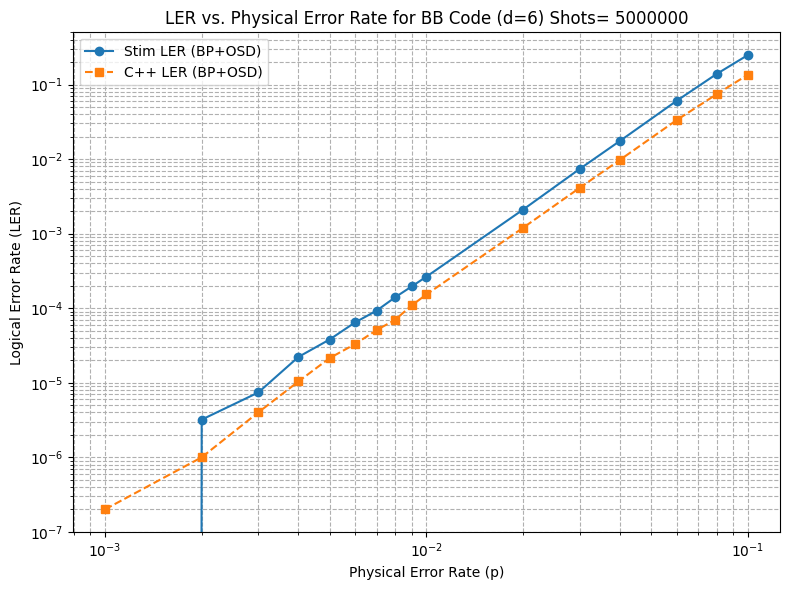

In [ ]:
# --- Plotting Results ---
plt.figure(figsize=(8, 6))

plt.plot(tau/T1, stim_logical_error_rates, 'o-', label='Stim LER (BP+OSD)')
plt.plot(tau/T1, cpp_logical_error_rates, 's--', label='C++ LER (BP+OSD)')
plt.xlabel("Physical Error Rate (p)")
plt.ylabel("Logical Error Rate (LER)")
plt.title(f"LER vs. Physical Error Rate for BB Code (d={distance}) Shots= {SHOTS}")
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --- Reload and plot previously saved results ---

# Ensure these parameters match the saved files you want to load
SHOTS = 2000000
distance = 6
T1 = 10**-4
T2 = 10**-4

results_dir = "./bposd_72_results"
stim_results_path = Path(results_dir) / f"stim_bposd_results_d{distance}_shots{SHOTS}.txt"
cpp_results_path = Path(results_dir) / f"cpp_bposd_results_d{distance}_shots{SHOTS}.txt"

# Check if files exist
if not stim_results_path.exists() or not cpp_results_path.exists():
    missing = []
    if not stim_results_path.exists(): missing.append(str(stim_results_path))
    if not cpp_results_path.exists(): missing.append(str(cpp_results_path))
    raise FileNotFoundError("Missing results files: " + ", ".join(missing))

# Function to load data from a tab-separated file
def load_results(path):
    data = np.loadtxt(path, comments='#', delimiter='\t')
    # Assuming columns are: tau, p_amp, p_phase, ler
    return data[:, 0], data[:, 3]

# Load data
tau_s, stim_ler_s = load_results(stim_results_path)
tau_c, cpp_ler_c = load_results(cpp_results_path)

# --- Plotting ---
plt.figure(figsize=(8, 6))
plt.plot(tau_s / T1, stim_ler_s, 'o-', label='Stim LER (BP+OSD) [loaded]')
plt.plot(tau_c / T1, cpp_ler_c, 's--', label='C++ LER (BP+OSD) [loaded]')

plt.xlabel(r"$\tau / T1$ Ratio")
plt.ylabel("Logical Error Rate (LER)")
plt.title(f"Loaded LER for BB Code (d={distance}), Shots={SHOTS}")
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.show()

FileNotFoundError: Missing results files: bposd_72_results/cpp_bposd_results_d6_shots2000000.txt